In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

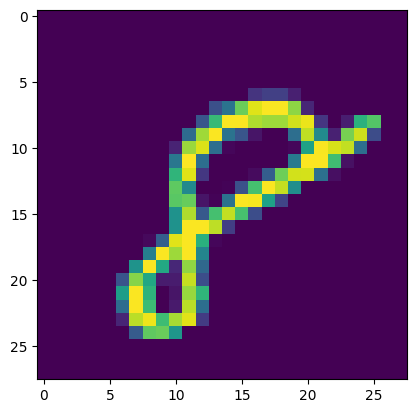

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

plt.imshow(x_train[-1])

In [4]:
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, num_clusters):
        super().__init__()
        self.input_dim = input_dim
        self.num_experts = num_clusters # suggestion that #clusters == #experts

        self.experts = [self.build_expert() for _ in range(self.num_experts)]
        self.gate = self.build_gate()

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts]
        gate_output = self.gate(inputs)
        weighted_expert_outputs = [tf.multiply(expert_output, tf.expand_dims(gate_output[:, i], axis=1))
                                   for i, expert_output in enumerate(expert_outputs)]
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        return aggregated_output

    def build_expert(self):
        """ Conv Autoencoder. """
        # Encoder
        inputs = Input(shape=self.input_dim)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Flatten()(x)
        latent_space = Dense(10, activation="relu")(x)

        # Decoder
        x = Dense(4 * 4 * 32, activation="relu")(latent_space)
        x = Reshape((4, 4, 32))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="valid")(x)
        x = UpSampling2D((2, 2))(x)
        outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

        # Autoencoder
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def build_gate(self):
        inputs = Input(shape=self.input_dim)
        x = Dense(self.num_experts, activation='softmax')(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        return model


input_dim = (28,28,1)
num_clusters = 10

model = MixtureOfExperts(input_dim, num_clusters)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [5]:
history = model.fit(
    x_train, x_train,
    epochs=1,
    batch_size=6,
    validation_data=(x_test, x_test)
)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 322s 30ms/step - loss: 0.0744 - mse: 0.0744 - val_loss: 0.0731 - val_mse: 0.0731


In [10]:
print("Test MSE Loss:", model.evaluate(x_test, x_test))

data_to_show = x_test[:10]
decoded_imgs = model.predict(data_to_show)
gate_output = model.gate.predict(data_to_show)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0685 - mse: 0.0685
Test MSE Loss: [0.07310072332620621, 0.07310071587562561]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


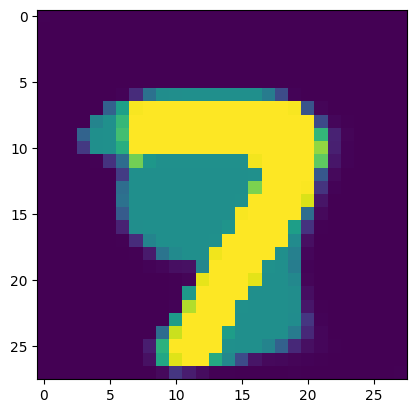

In [11]:
im = decoded_imgs[0]
im = np.mean(im, axis=2)
plt.imshow(im)

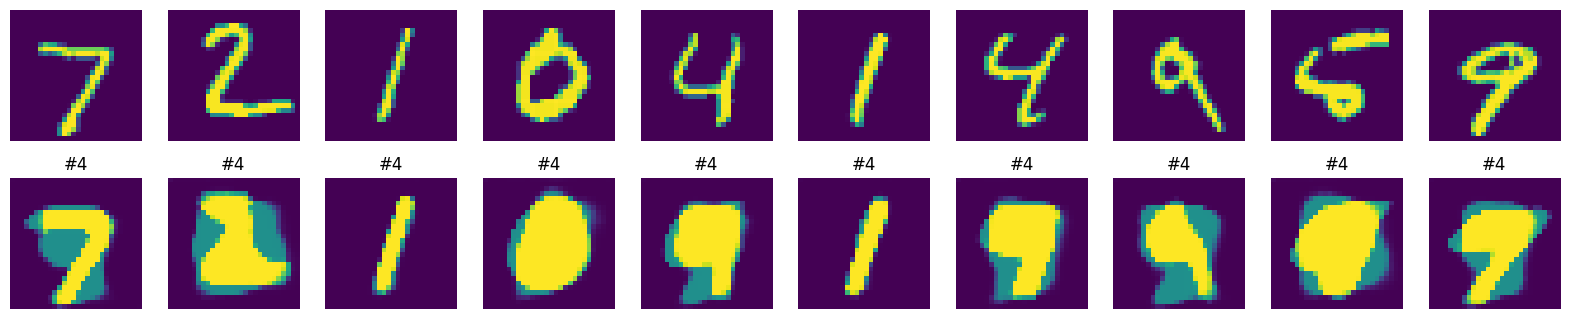

In [8]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].squeeze())
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, 10, i + 11)
    im = decoded_imgs[i]
    im = np.mean(im, axis=2)
    indx = np.argmax(gate_output[i])
    plt.title(f"#{indx}")
    plt.imshow(im)
    plt.axis('off')

plt.show()


In [9]:
gate_output = model.gate.predict(x_test)
assigned_clusters = np.argmax(gate_output, axis=1)
assigned_clusters

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 